In [ ]:
%load_ext autoreload
%autoreload 2

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

/home/eecs/ivalexander13/datadir/miniconda3/envs/cass/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/eecs/ivalexander13/datadir/miniconda3/envs/cass/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/eecs/ivalexander13/datadir/miniconda3/envs/cass/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [17]:
RF_df_iwhd = pd.read_csv("data/scores/nj_iwhd.robinson_foulds.tsv", sep="\t")
triplets_df_iwhd = pd.read_csv("data/scores/nj_iwhd.triplets_correct.tsv", sep="\t")

RF_df_nj = pd.read_csv("data/scores/nj.robinson_foulds.tsv", sep="\t")
triplets_df_nj = pd.read_csv("data/scores/nj.triplets_correct.tsv", sep="\t")

RF_df = pd.concat([RF_df_iwhd, RF_df_nj])
triplets_df = pd.concat([triplets_df_iwhd, triplets_df_nj])

RF_df.head()

,NumberOfCells,Priors,Fitness,Stressor,Parameter,Algorithm,Replicate,UnNormalizedRobinsonFoulds,MaxRobinsonFoulds,NormalizedRobinsonFoulds
0,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,5,1754,3556,0.493251
1,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,31,1863,3495,0.533047
2,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,46,2017,3461,0.582780
3,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,10,1884,3488,0.540138
4,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,28,1656,3500,0.473143


In [135]:
# Convert to str
RF_df[["Parameter", "Replicate"]] = RF_df[["Parameter", "Replicate"]].astype(str)
triplets_df[["Parameter", "Replicate"]] = triplets_df[["Parameter", "Replicate"]].astype(str)

In [240]:
split_cols_by = [
    # "Algorithm",
    # "NumberOfCells",
    # "Priors",
    "Fitness",
    "Stressor",
    "Parameter",
]

def apply_name(row):
    list_name = [row[col] for col in split_cols_by]
    return ' | '.join(list_name)

RF_df['name'] = RF_df.apply(apply_name, axis=1)

triplets_df['name'] = triplets_df.apply(apply_name, axis=1)
triplets_df = triplets_df.groupby(['name', 'Algorithm', 'Replicate'], as_index=False).mean().drop(columns=['Depth'])
RF_df.head()

,NumberOfCells,Priors,Fitness,Stressor,Parameter,Algorithm,Replicate,UnNormalizedRobinsonFoulds,MaxRobinsonFoulds,NormalizedRobinsonFoulds,name
0,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,5,1754,3556,0.493251,no_fit | stoch_high_drop | 30
1,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,31,1863,3495,0.533047,no_fit | stoch_high_drop | 30
2,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,46,2017,3461,0.582780,no_fit | stoch_high_drop | 30
3,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,10,1884,3488,0.540138,no_fit | stoch_high_drop | 30
4,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,28,1656,3500,0.473143,no_fit | stoch_high_drop | 30


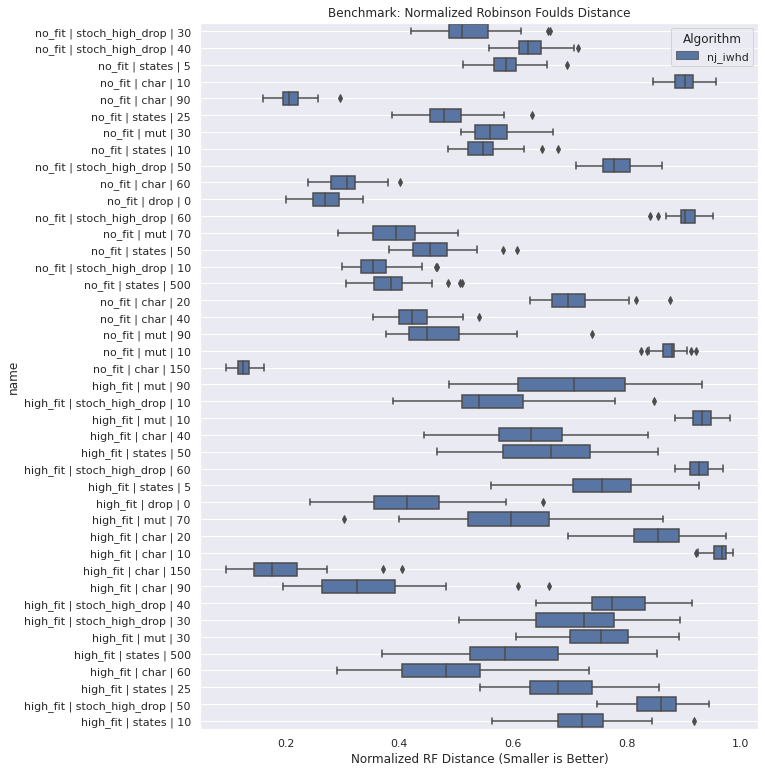

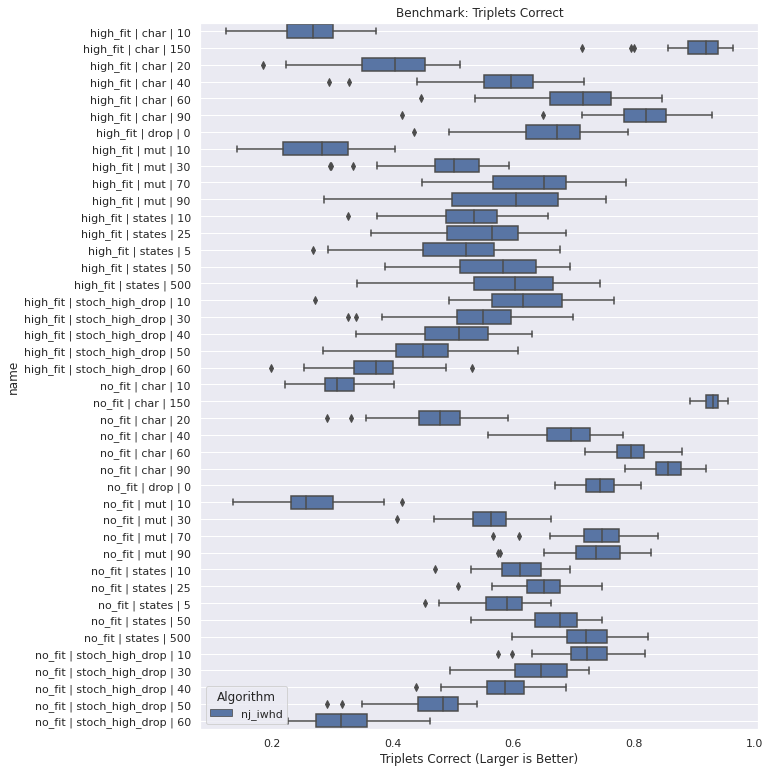

In [245]:
sns.set(rc={'figure.figsize': (10, 13)})

# Plot metrics
rf_vars = {
    'df': RF_df,
    'title': 'Benchmark: Normalized Robinson Foulds Distance',
    'x_label': 'Normalized RF Distance (Smaller is Better)',
    'outfile': 'plots/rf_benchmark.png',
    'colname': 'NormalizedRobinsonFoulds'
}
triplets_vars = {
    'df': triplets_df,
    'title': 'Benchmark: Triplets Correct',
    'x_label': 'Triplets Correct (Larger is Better)',
    'outfile': 'plots/triplets_benchmark.png',
    'colname': 'TripletsCorrect'
}

for vars in [rf_vars, triplets_vars]:
    bp = sns.boxplot(
        y='name', 
        x=vars['colname'],
        data=vars['df'], 
        hue='Algorithm', 
        # width=0.2
        )
    plt.title(vars['title'])
    plt.xlabel(vars['x_label'])
    plt.grid(which='major')
    plt.show()

In [193]:
split_cols_by = [
    # "NumberOfCells",
    # "Priors",
    "Fitness",
    "Stressor",
    "Parameter",
    "Algorithm",
]

RF_df_out = pd.DataFrame()
triplets_df_out = pd.DataFrame()

for df_in, main_col, df_out in [
    (RF_df, "NormalizedRobinsonFoulds", RF_df_out), 
    (triplets_df, "TripletsCorrect", triplets_df_out)
    ]:
    grouped = df_in.groupby(split_cols_by)
    for group in grouped.groups:
        group_df = grouped.get_group(group).groupby("Replicate").mean()
        name = ' | '.join(group)
        df_out[name] = pd.Series(group_df[main_col].values)

    df_out = df_out.reindex(sorted(df_out.columns), axis=1)


<Figure size 432x288 with 0 Axes>

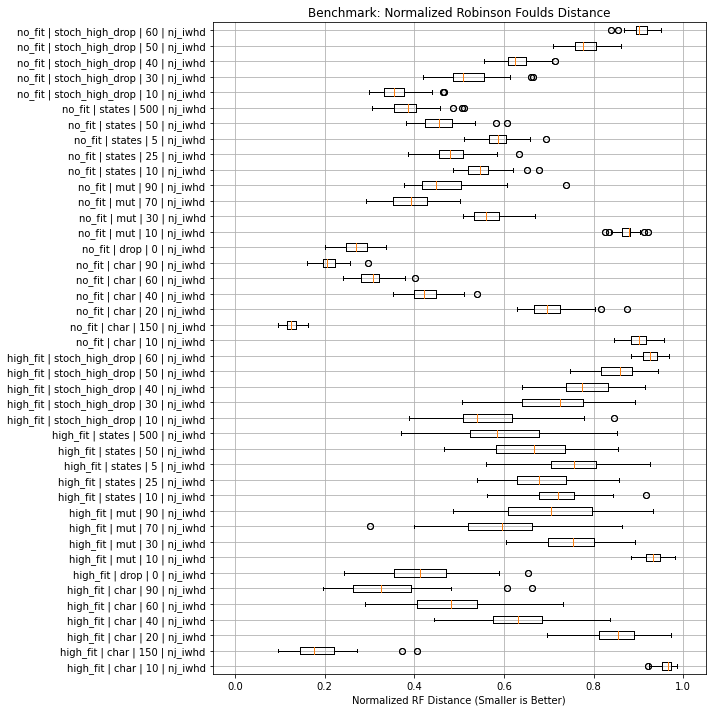

<Figure size 432x288 with 0 Axes>

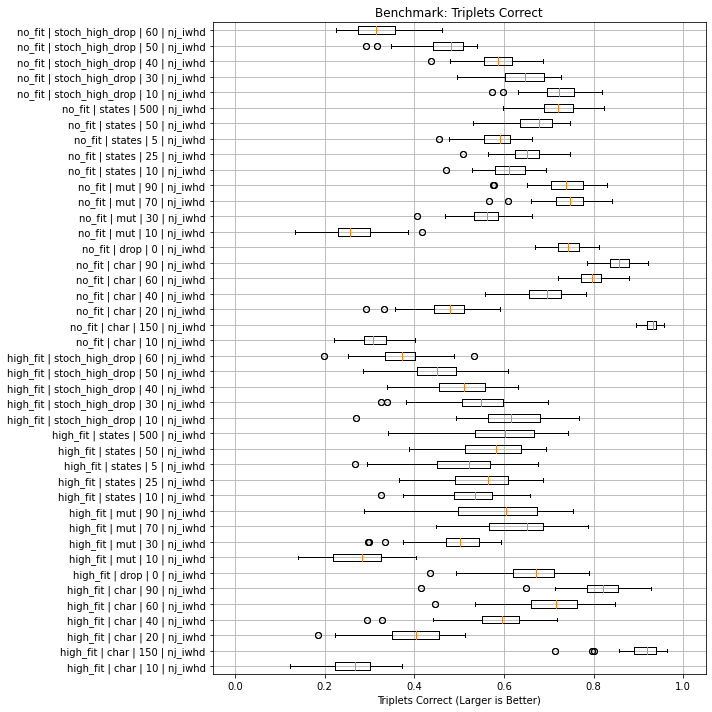

In [196]:
# Plot metrics
rf_vars = {
    'df': RF_df_out,
    'title': 'Benchmark: Normalized Robinson Foulds Distance',
    'x_label': 'Normalized RF Distance (Smaller is Better)',
    'outfile': 'plots/rf_benchmark.png',
}
triplets_vars = {
    'df': triplets_df_out,
    'title': 'Benchmark: Triplets Correct',
    'x_label': 'Triplets Correct (Larger is Better)',
    'outfile': 'plots/triplets_benchmark.png',
}

for vars in [rf_vars, triplets_vars]:
    names = []
    yticks = []
    for name in vars['df'].columns:
        names.append(vars['df'][name])
        yticks.append(name)

    # File out
    Path(vars['outfile']).parent.mkdir(parents=True, exist_ok=True)

    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.boxplot(names, vert = 0)
    ax.boxplot(names, vert = 0)
    plt.title(vars['title'])
    plt.xlabel(vars['x_label'])
    plt.yticks(list(range(1, len(vars['df'].columns) + 1)), yticks)
    # plt.xlim(0.07, 0.76)
    plt.xlim(-0.05, 1.05)
    plt.grid()
    plt.tight_layout()
    plt.savefig(vars['outfile'])
    plt.show();